In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Eff_area"
)
from my_dataset_maps_20 import MapDatasetNuisance
from MapDatasetNuisanceE import MapDatasetNuisanceE
from  my_fit_20 import Fit
from Dataset_Creation_e_dependent import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : FGBqd9AR 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

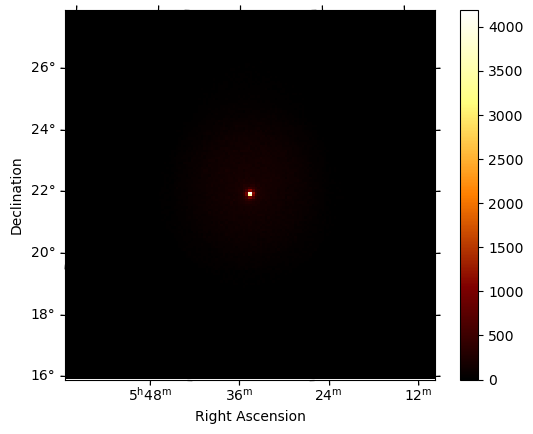

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

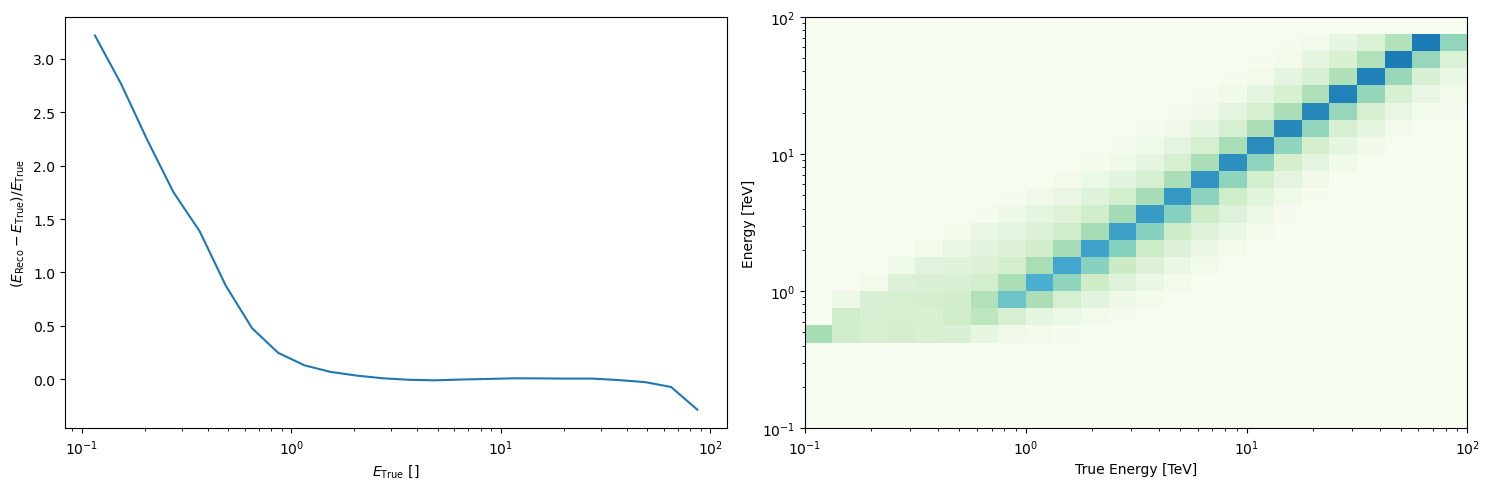

In [4]:
dataset_standard.edisp.peek()

## Varying the Exposure

In [6]:
tilt_neg =0.08/24 # 4e-3
tilt_pos = -tilt_neg
tilt_cor = 0

shift_neg = 0.1
shift_pos = -0.1
shift_cor = 0.0


true_energy = dataset_standard.exposure.geom.axes[0].center.value

# -tilt * x + (1+shift) 
    

In [7]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

In [8]:
sys_d_cor = sys_dataset(dataset_asimov = dataset_asimov,
                        tilt = tilt_cor, 
                        shift = shift_cor,
                        rnd =  False)
dataset_cor = sys_d_cor.create_dataset()

sys_d_neg = sys_dataset(dataset_asimov = dataset_asimov,
                        tilt = tilt_neg, 
                        shift = shift_neg,
                        rnd =  False)
dataset_neg = sys_d_neg.create_dataset()

sys_d_pos = sys_dataset(dataset_asimov = dataset_asimov,
                        tilt = tilt_pos, 
                        shift = shift_pos,
                        rnd =  False)
dataset_pos = sys_d_pos.create_dataset()



In [9]:
exposure_standard = dataset_standard.exposure#.data.sum(axis=2).sum(axis=1)
exposure_e = dataset_cor.exposure.data.sum(axis=2).sum(axis=1)


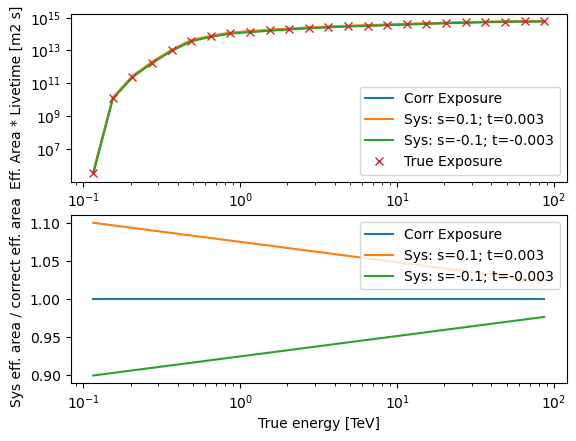

In [12]:
fig,ax = plt.subplots(2,1)

exposure_standard = dataset_standard.exposure.data.sum(axis=2).sum(axis=1)
exposure_e = dataset_cor.exposure.data.sum(axis=2).sum(axis=1)

ax[0].plot(true_energy, exposure_e, label = "Corr Exposure")
ax[0].plot(true_energy, dataset_neg.exposure.data.sum(axis =2).sum(axis =1),
           label = f'Sys: s={shift_neg:.1}; t={tilt_neg:.1}')
ax[0].plot(true_energy, sum_e(dataset_pos.exposure.data), 
           label = f'Sys: s={shift_pos:.1}; t={tilt_pos:.1}')
ax[0].plot(true_energy, exposure_standard, 'x', label = "True Exposure")

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel("True energy [TeV]")
ax[0].set_ylabel(f"Eff. Area * Livetime [{dataset_standard.exposure.unit}]")
ax[0].legend()

ax[1].plot(true_energy, exposure_e/exposure_standard, label = "Corr Exposure")
ax[1].plot(true_energy, sum_e(dataset_neg.exposure.data)/exposure_e,
           label = f'Sys: s={shift_neg:.1}; t={tilt_neg:.1}')
ax[1].plot(true_energy, sum_e(dataset_pos.exposure.data)/ exposure_e, 
           label = f'Sys: s={shift_pos:.1}; t={tilt_pos:.1}')

#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel("True energy [TeV]")
ax[1].set_ylabel(f"Sys eff. area / correct eff. area ")
ax[1].legend()

fig.savefig("plots/1_exposure_example.pdf")

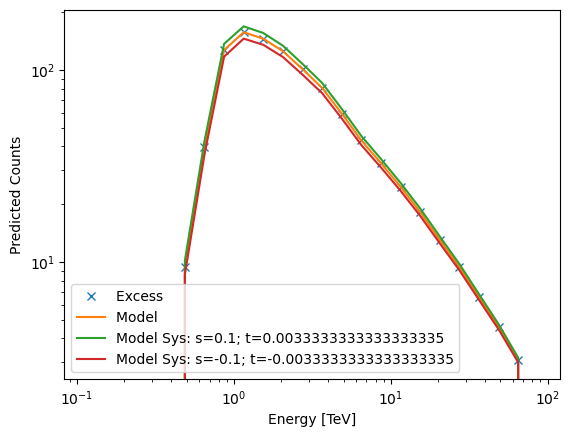

In [14]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

npred = dataset_cor.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_neg = dataset_neg.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_pos = dataset_pos.npred_signal().data.sum(axis = 2).sum(axis= 1)

excess = sum_e(dataset_asimov.counts.data) - sum_e(dataset_asimov.background.data)
plt.plot(true_energy, excess,'x', label = "Excess ")
plt.plot(true_energy, npred, label = "Model ")
plt.plot(true_energy, npred_neg, label = f'Model Sys: s={shift_neg:.1}; t={tilt_neg:.1}')
plt.plot(true_energy, npred_pos, label = f'Model Sys: s={shift_pos:.1}; t={tilt_pos:.1}')

         
plt.loglog()
plt.legend()
plt.xlabel("Energy [TeV]")
plt.ylabel("Predicted Counts")

fig = plt.gcf()
fig.savefig("plots/1_counts.pdf")

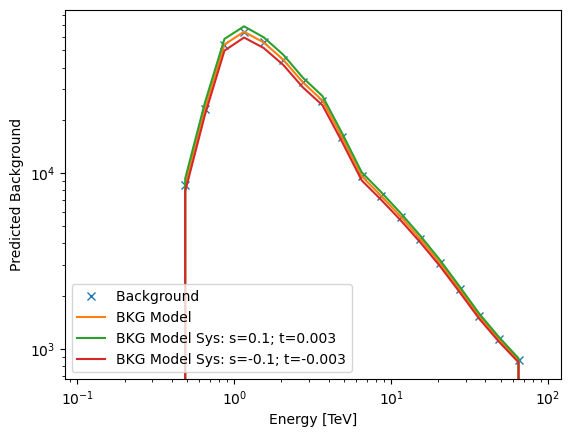

In [16]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

npred = dataset_cor.npred_background().data.sum(axis = 2).sum(axis= 1)
npred_neg = dataset_neg.npred_background().data.sum(axis = 2).sum(axis= 1)
npred_pos = dataset_pos.npred_background().data.sum(axis = 2).sum(axis= 1)


plt.plot(true_energy, dataset_standard.background.data.sum(axis = 2).sum(axis= 1),'x', label = "Background ")
plt.plot(true_energy, npred, label = "BKG Model ")
plt.plot(true_energy, npred_neg, label = f'BKG Model Sys: s={shift_neg:.1}; t={tilt_neg:.1}')
plt.plot(true_energy, npred_pos, label = f'BKG Model Sys: s={shift_pos:.1}; t={tilt_pos:.1}')

         
plt.loglog()
plt.legend()
plt.xlabel("Energy [TeV]")
plt.ylabel("Predicted Background")

fig = plt.gcf()
fig.savefig("plots/1_counts.pdf")

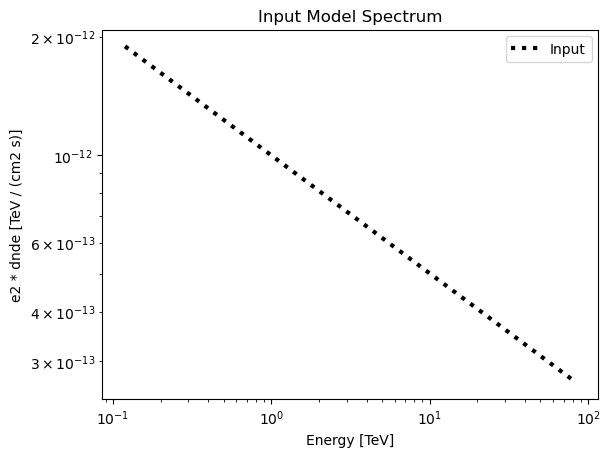

In [17]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
#dataset_cor.models['Source'].spectral_model.plot(energy_bounds, label = "Spectrum")
#dataset_neg.models['Source'].spectral_model.plot(energy_bounds, label = "")
#dataset_pos.models['Source'].spectral_model.plot(energy_bounds, label = "")
dataset_standard.models['Source'].spectral_model.plot(energy_bounds, energy_power = 2,
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')
plt.title("Input Model Spectrum")
plt.legend()

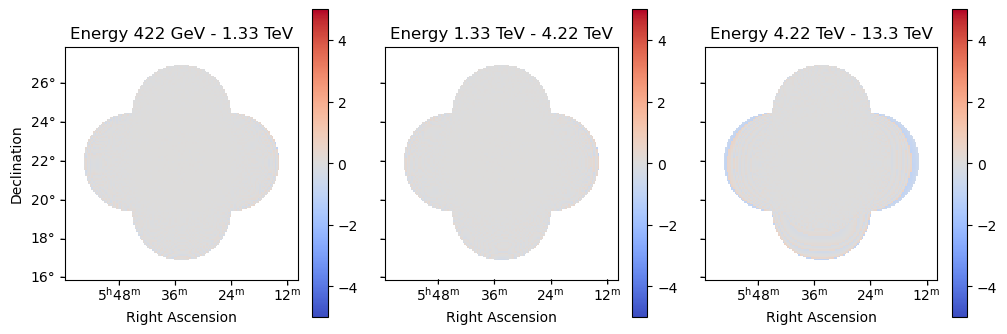

In [18]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.2 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[5:20:4])
result = estimator.run(dataset_cor)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

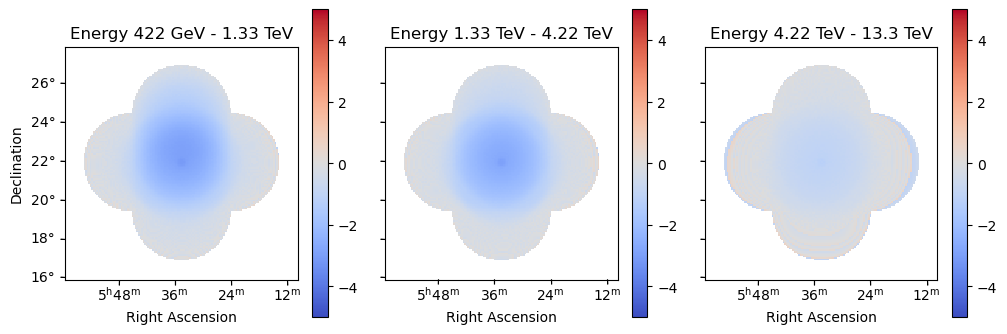

In [19]:
result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

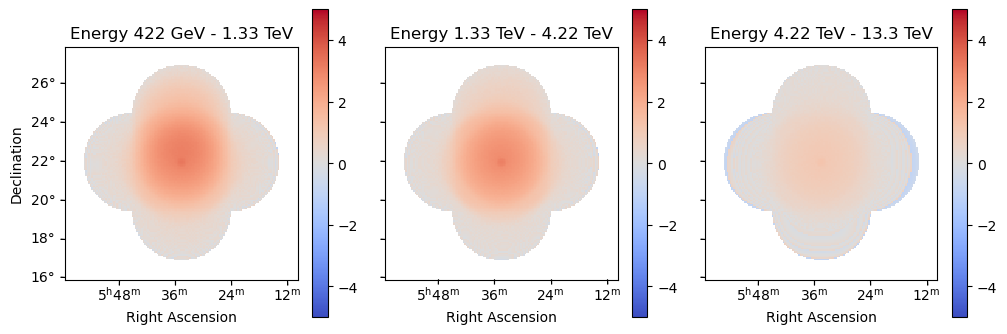

In [20]:
result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

In [21]:
%%time
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_cor])
fit_neg = Fit(store_trace=False)
result_neg = fit_neg.run([dataset_neg])
fit_pos = Fit(store_trace=False)
result_pos = fit_pos.run([dataset_pos])

CPU times: user 7.04 s, sys: 28.7 ms, total: 7.07 s
Wall time: 7.09 s


In [22]:
datasets_short = [dataset_neg, dataset_cor, dataset_pos]
print("best fit amplitude")
amplitudes = []
m = dataset_standard.models['Source']
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes.append((value, error))
    print(f'{value} pm {error}')
print()
print("best fit Index")
indices = []
m = dataset_standard.models['Source']
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms = []
value = dataset_standard.background_model.parameters['norm'].value 
error = dataset_standard.background_model.parameters['norm'].error
norms.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms.append((value, error))
    
print("Best Fit bkg tilt")
tilts = []
value = dataset_standard.background_model.parameters['tilt'].value 
error = dataset_standard.background_model.parameters['tilt'].error
tilts.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['tilt'].value 
    error = d.background_model.parameters['tilt'].error
    print(f'{value} pm {error}')
    tilts.append((value, error))
    
    
with open('data/norms.yaml', 'w') as file:
    documents = yaml.dump(norms, file)
with open('data/tilts.yaml', 'w') as file:
    documents = yaml.dump(tilts, file)
with open('data/amplitudes.yaml', 'w') as file:
    documents = yaml.dump(amplitudes, file)
with open('data/indices.yaml', 'w') as file:
    documents = yaml.dump(indices, file)
    
dataset_neg.models.write("data/1_model_neg.yml", overwrite= True)
dataset_pos.models.write("data/1_model_pos.yml", overwrite= True)
dataset_cor.models.write("data/1_model_cor.yml", overwrite= True)

best fit amplitude
====
Input
1e-12 pm 0
====
9.311363343317182e-13 pm 8.367033326798146e-14
1e-12 pm 8.982377778353663e-14
1.0818619418957385e-12 pm 9.726819805743652e-14

best fit Index
====
Input
2.3 pm 0
====
2.288474015969725 pm 0.06164859978161923
2.3 pm 0.061716371768353546
2.311178262392356 pm 0.06159944865691272

Best Fit bkg Norm
====
Input
1.0 pm 0
====
0.9301887236014956 pm 0.0019217176908738196
1.0 pm 0.00206238916408096
1.0810414440022185 pm 0.0022334368658325373
Best Fit bkg tilt
====
Input
0.0 pm 0
====
-0.010895262377635424 pm 0.001961340297038736
0.0 pm 0.0019579168550766806
0.012313456282939235 pm 0.0019612970083089203


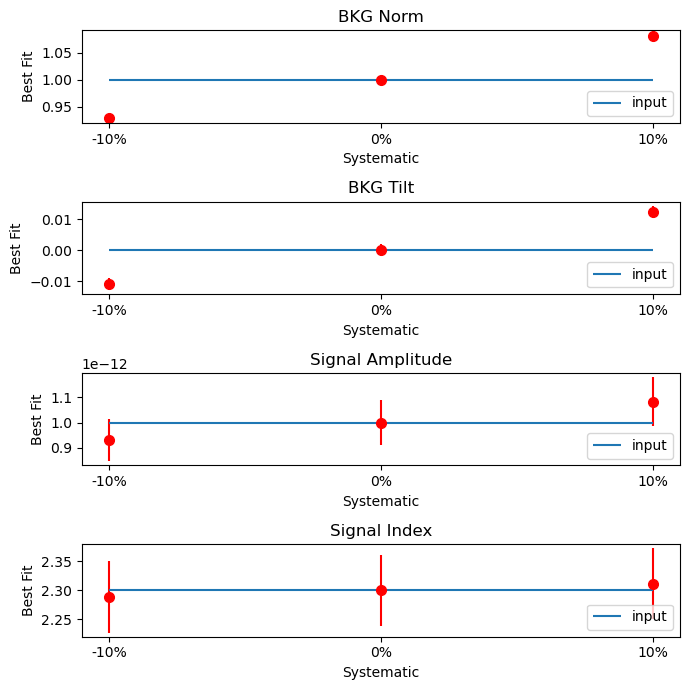

In [23]:
fig, axs = plt.subplots(4,1, figsize = (7,7))

axs[0].set_title("BKG Norm")
axs[1].set_title("BKG Tilt")
axs[2].set_title("Signal Amplitude")
axs[3].set_title("Signal Index")


labels = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[0].hlines( norms[0][0], 1, 3, label = "input")

for i, a in enumerate(tilts[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[1].hlines( tilts[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[2].hlines( amplitudes[0][0], 1, 3, label = "input")

for i, a in enumerate(indices[1:]):
    axs[3].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[3].hlines( indices[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    a.legend(loc = 'lower right'); 
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels)

plt.tight_layout()    
fig.savefig("plots/1_best_fit_parameters_nocorr.pdf")   


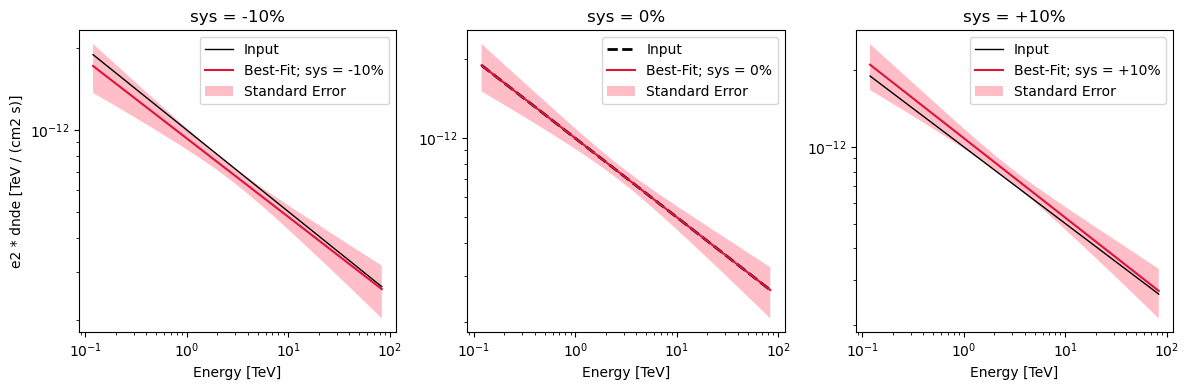

In [24]:
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

fig,axs = plt.subplots(1,3, sharey=False,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )

dataset_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1_spectrum_standard.pdf")

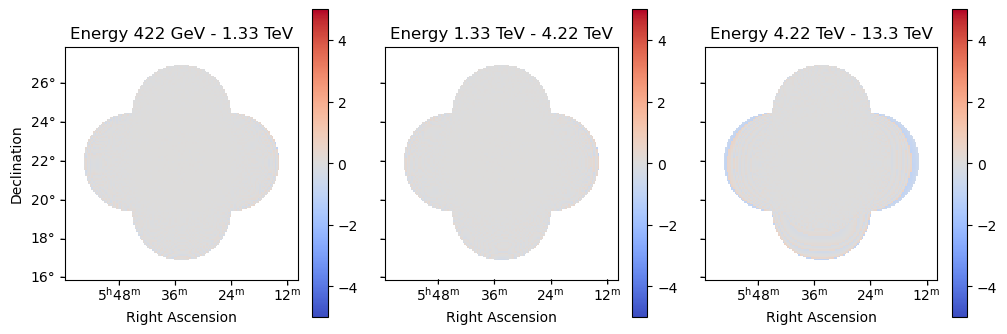

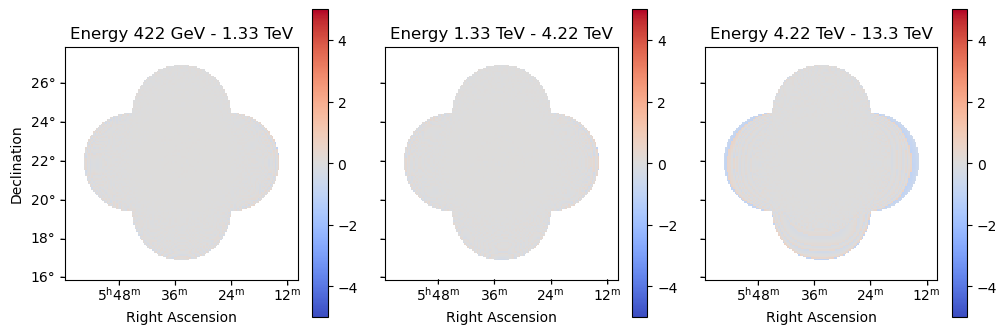

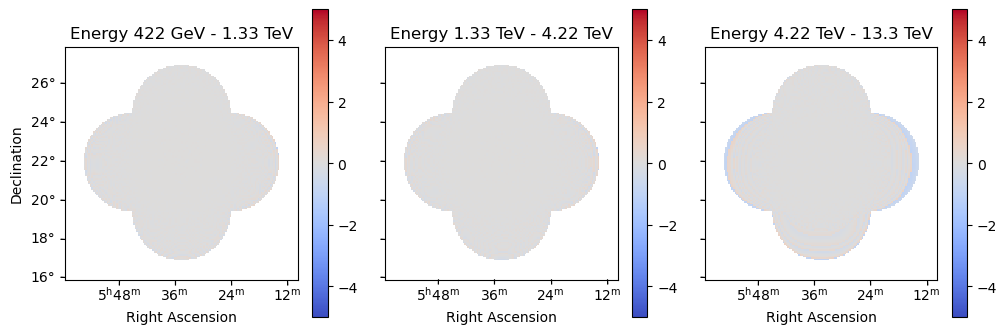

In [25]:

estimator = ExcessMapEstimator(
    correlation_radius=f"0.2 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[5:20:4])
result = estimator.run(dataset_cor)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);


result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);


result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

## Mulitple Poission Draws

In [27]:
N = 1
datasets_cor = []
datasets_neg = []
datasets_pos = []

sys_d_cor_rnd = sys_dataset(dataset_asimov = dataset_asimov,
                        tilt = tilt_cor, 
                        shift = shift_cor,
                        rnd =  True)
sys_d_neg_rnd = sys_dataset(dataset_asimov = dataset_asimov,
                        tilt = tilt_neg, 
                        shift = shift_neg,
                        rnd =  True)
sys_d_pos_rnd = sys_dataset(dataset_asimov = dataset_asimov,
                        tilt = tilt_pos, 
                        shift = shift_pos,
                        rnd =  True)


for n in range(N):
    datasets_cor.append(sys_d_cor_rnd.create_dataset())
    datasets_neg.append(sys_d_neg_rnd.create_dataset())
    datasets_pos.append(sys_d_pos_rnd.create_dataset())


In [28]:
%%time


fitting_poission_draws = False


if fitting_poission_draws:
    for i, d in enumerate(datasets_cor):
        print(i)
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([d])
    for i, d in enumerate( datasets_neg):
        print(i)
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([d])
    for i, d in enumerate (datasets_pos):
        print(i)
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([d])
        
        
    amplitudes_all = []
    indices_all = []
    norms_all = []
    tilts_all =[]

    datasets_p = [datasets_neg, datasets_cor, datasets_pos]
    for d_case in datasets_p:
        print("best fit amplitude")
        amplitudes_p = []
        print('====')
        for d in d_case:
            m = d.models['Source']
            value = m.parameters['amplitude'].value 
            error = m.parameters['amplitude'].error
            amplitudes_p.append((value, error))
            print(f'{value} pm {error}')
        print()
        print("best fit Index")
        indices_p = []
        print('====')
        for d in d_case:
            m = d.models['Source']
            value = m.parameters['index'].value 
            error = m.parameters['index'].error
            indices_p.append((value, error))
            print(f'{value} pm {error}')
        print()

        print("Best Fit bkg Norm")
        norms_p = []
        print('====')
        for d in d_case:
            value = d.background_model.parameters['norm'].value 
            error = d.background_model.parameters['norm'].error
            print(f'{value} pm {error}')
            norms_p.append((value, error))
            
        print("Best Fit bkg Norm")
        tilts_p = []
        print('====')
        for d in d_case:
            value = d.background_model.parameters['tilt'].value 
            error = d.background_model.parameters['tilt'].error
            print(f'{value} pm {error}')
            tilts_p.append((value, error))

        amplitudes_all.append(amplitudes_p)
        indices_all.append(indices_p)
        norms_all.append(norms_p)   
        tilts_all.append(tilts_p)    
        
    with open('data/norms_all.yaml', 'w') as file:
        documents = yaml.dump(norms_all, file)
    with open('data/tilts_all.yaml', 'w') as file:
        documents = yaml.dump(tilts_all, file)
    with open('data/amplitudes_all.yaml', 'w') as file:
        documents = yaml.dump(amplitudes_all, file)
    with open('data/indices_all.yaml', 'w') as file:
        documents = yaml.dump(indices_all, file)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs


In [29]:
if ~fitting_poission_draws:
    with open('data/norms_all.yaml') as file:
        norms_all = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/amplitudes_all.yaml') as file:
        amplitudes_all = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/indices_all.yaml') as file:
        indices_all = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/tilts_all.yaml') as file:
        tilts_all = yaml.load( file, Loader=yaml.FullLoader)

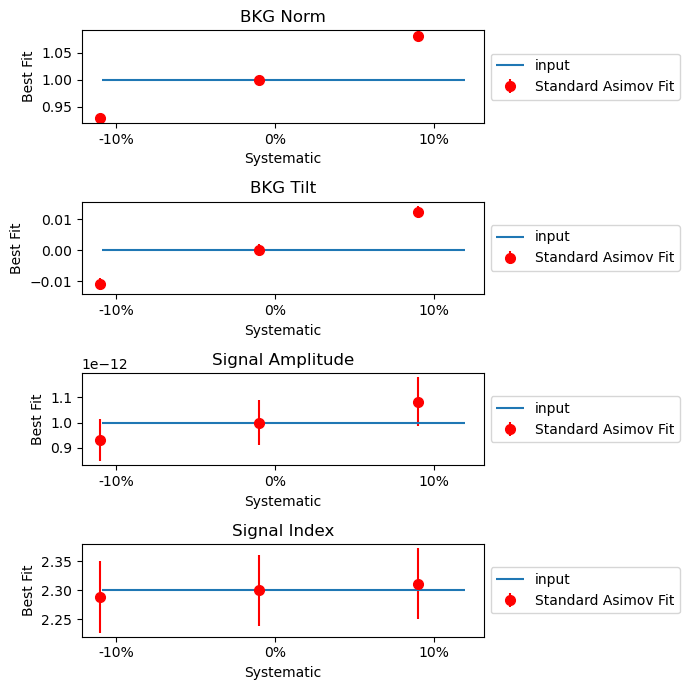

In [30]:
fig, axs = plt.subplots(4,1, figsize = (7,7))

axs[0].set_title("BKG Norm")
axs[1].set_title("BKG Tilt")
axs[2].set_title("Signal Amplitude")
axs[3].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    label = 'Standard Asimov Fit'
    axs[0].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(tilts[1:]):
    axs[1].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
    
for i, a in enumerate(amplitudes[1:]):
    axs[2].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(indices[1:]):
    axs[3].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)

for j in range(3):
    label = 'Standard Rnd Fit'
    
    for i, a in enumerate(norms_all[j][1:]):
        axs[0].errorbar(x= 0.95+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'orange',
                       label = label)
    for i, a in enumerate(tilts_all[j][1:]):
        axs[1].errorbar(x= 0.95+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'orange',
                       label = label)
    for i, a in enumerate(amplitudes_all[j][1:]):
        axs[2].errorbar(x= 0.95+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'orange',
                       label = label)
    for i, a in enumerate(indices_all[j][1:]):
        axs[3].errorbar(x= 0.95+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'orange',
                       label = label)

        
axs[0].hlines( norms[0][0], 0.91, 3.2, label = "input")
axs[1].hlines( tilts[0][0], 0.91, 3.2, label = "input")    
axs[2].hlines( amplitudes[0][0], 0.91, 3.2, label = "input")
axs[3].hlines( indices[0][0], 0.91, 3.2, label = "input")

plt.tight_layout()
for a in axs:
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1, 0.5))
    
    #a.legend(); 
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels_sys)

plt.tight_layout()    
fig.savefig("plots/1_best_fit_parameters_nocorr.pdf")   
